In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import json
import pickle

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN, loadMNIST, inference_time, plot_loss, plot_acc, plot_shifts, ASL_plot_acc, ASL_plot_loss

plt.rcParams['figure.dpi'] = 100

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100
input_shape = (batch_size, 1, 28, 28)
num_labels = 10

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadMNIST(batch_size)

## MNIST LeNet

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet/LeNet_optimizer.pkl', 'rb') as file:
    LeNet_optim = pickle.load(file)

best_parameters = LeNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[1]

[{'acc': 99.70666666666666, 'lr': 0.21875, 'momentum': 0.78125, 'p_randomTransform': 0.0625}, {'acc': 99.645, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}, {'acc': 99.625, 'lr': 0.491943359375, 'momentum': 0.589599609375, 'p_randomTransform': 0.04345703125}]


In [5]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels=num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Conv2d: 2-5                       [100, 16, 14, 14]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 14, 14]         32
│    └─Tanh: 2-7                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-8                    [100, 16, 7, 7]           --
│    └─Flatten: 2-9                      [100, 784]                --
│    └─Linear: 2-10                      [100, 120]                94,200
│    └─Tanh: 2-11                        [100, 120]                --
│    └─

In [6]:
PATH = "models/LeNet/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [6]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2, device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 0.924
test_loss: 0.365, test_accuracy: 89.75
[1,   200] train_loss: 0.405
test_loss: 0.254, test_accuracy: 92.47
[1,   300] train_loss: 0.316
test_loss: 0.377, test_accuracy: 87.98
[1,   400] train_loss: 0.225
test_loss: 0.203, test_accuracy: 93.75
[1,   500] train_loss: 0.168
test_loss: 0.202, test_accuracy: 93.57
[1,   600] train_loss: 0.134
test_loss: 0.197, test_accuracy: 93.88
[2,   100] train_loss: 0.135
test_loss: 0.106, test_accuracy: 96.65
[2,   200] train_loss: 0.139
test_loss: 0.178, test_accuracy: 94.47
[2,   300] train_loss: 0.111
test_loss: 0.085, test_accuracy: 97.32
[2,   400] train_loss: 0.084
test_loss: 0.300, test_accuracy: 90.05
[2,   500] train_loss: 0.089
test_loss: 0.129, test_accuracy: 95.95
[2,   600] train_loss: 0.090
test_loss: 0.070, test_accuracy: 97.7
[3,   100] train_loss: 0.073
test_loss: 0.201, test_accuracy: 93.48
[3,   200] train_loss: 0.082
test_loss: 0.129, test_accuracy: 96.08
[3,   300] train_loss: 0.091
test_loss: 0.084, te

In [7]:
torch.save(LeNN, "./models/LeNet/LeNet.pth")

In [4]:
LeNN = torch.load("./models/LeNet/LeNet.pth")

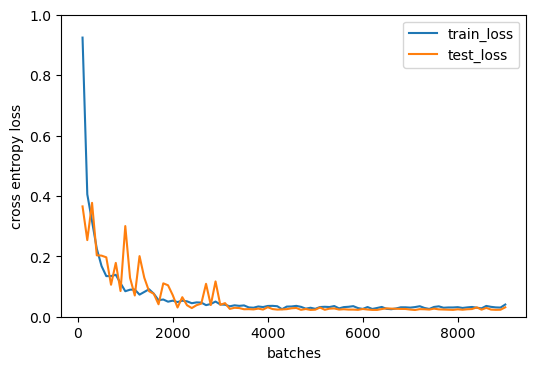

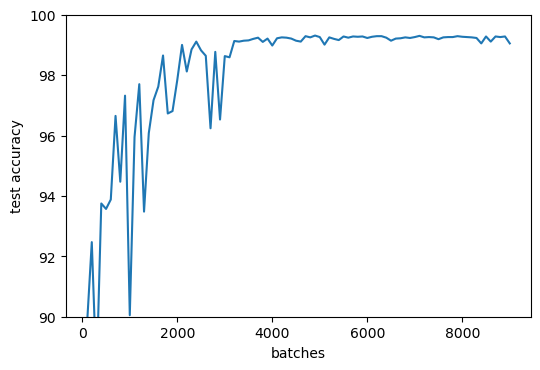

In [5]:
plot_loss(LeNN, y_lim=(0,1))
plot_acc(LeNN, y_lim=(90, 100))

In [5]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeNN.train_time), 3)}")
print(f"std: {round(np.std(LeNN.train_time), 3)}")

Training time (s):
mean: 0.703
std: 0.138


In [13]:
inference_times = inference_time(LeNN, input_shape=(1, 1, 28, 28), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
3.195e-01
4.5e-02


In [14]:
inference_times = inference_time(LeNN, input_shape=(1, 1, 28, 28), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
3.224e-01
4.6e-02


In [15]:
inference_times = inference_time(LeNN, input_shape=(100, 1, 28, 28), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.967e+00
3.7e-02


In [16]:
inference_times = inference_time(LeNN, input_shape=(100, 1, 28, 28), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
2.198e+00
6.7e-01


## MNIST LeASLNet

In [7]:
# mock train_function of Optimizer to load the optimizer
ASL_train_function = None

with open('models/LeNet/LeASLNet_optimizer.pkl', 'rb') as file:
    LeASLNet_optim = pickle.load(file)

best_parameters = LeASLNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[2]

[{'acc': 99.64666666666666, 'lr': 0.4318430270465593, 'momentum': 0.5504980468750001, 'p_randomTransform': 0.00041015625000001554}, {'acc': 99.52166666666666, 'lr': 0.47607421875, 'momentum': 0.51025390625, 'p_randomTransform': 0.0224609375}, {'acc': 99.27666666666667, 'lr': 0.031142578125000014, 'momentum': 0.9078222656249999, 'p_randomTransform': 0.5410533338955021}]


In [8]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─CSC_block: 2-5                    [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 14, 14]         112
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─T

In [16]:
PATH = "models/LeNet/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [9]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeASLNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.314
test_loss: 0.823, test_accuracy: 73.87
[1,   200] train_loss: 0.626
test_loss: 0.402, test_accuracy: 87.24
[1,   300] train_loss: 0.393
test_loss: 0.227, test_accuracy: 93.23
[1,   400] train_loss: 0.302
test_loss: 0.161, test_accuracy: 95.15
[1,   500] train_loss: 0.228
test_loss: 0.125, test_accuracy: 96.05
[1,   600] train_loss: 0.244
test_loss: 0.112, test_accuracy: 96.57
[2,   100] train_loss: 0.159
test_loss: 0.107, test_accuracy: 96.77
[2,   200] train_loss: 0.157
test_loss: 0.090, test_accuracy: 96.97
[2,   300] train_loss: 0.173
test_loss: 0.091, test_accuracy: 97.24
[2,   400] train_loss: 0.131
test_loss: 0.084, test_accuracy: 97.28
[2,   500] train_loss: 0.113
test_loss: 0.068, test_accuracy: 98.05
[2,   600] train_loss: 0.123
test_loss: 0.068, test_accuracy: 97.75
[3,   100] train_loss: 0.125
test_loss: 0.089, test_accuracy: 97.08
[3,   200] train_loss: 0.108
test_loss: 0.062, test_accuracy: 98.04
[3,   300] train_loss: 0.094
test_loss: 0.060, t

In [10]:
torch.save(LeASLNN, "./models/LeNet/LeASLNet.pth")

In [11]:
LeASLNN = torch.load("./models/LeNet/LeASLNet.pth")

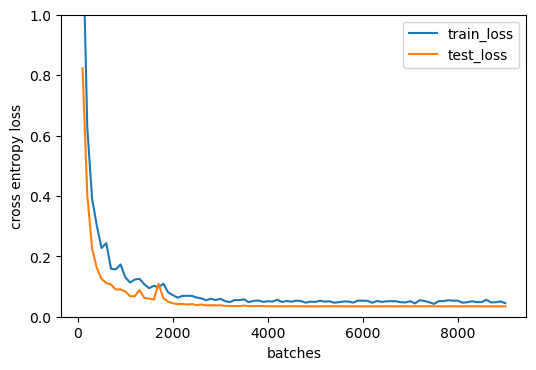

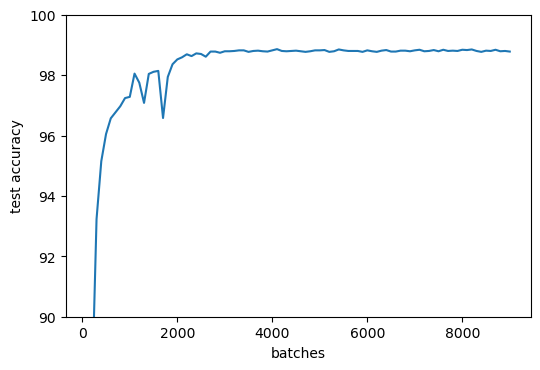

In [5]:
plot_loss(LeASLNN, y_lim=(0,1))
plot_acc(LeASLNN, y_lim=(90,100))

In [5]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeASLNN.train_time), 3)}")
print(f"std: {round(np.std(LeASLNN.train_time), 3)}")

Training time (s):
mean: 0.661
std: 0.128


In [23]:
inference_times = inference_time(LeASLNN, input_shape=(1, 1, 28, 28), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.175e+00
1.7e-01


In [24]:
inference_times = inference_time(LeASLNN, input_shape=(1, 1, 28, 28), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
6.789e-01
1.6e-01


In [21]:
inference_times = inference_time(LeASLNN, input_shape=(100, 1, 28, 28), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.909e+00
7.8e-02


In [22]:
inference_times = inference_time(LeASLNN, input_shape=(100, 1, 28, 28), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
3.076e+00
5.7e-01


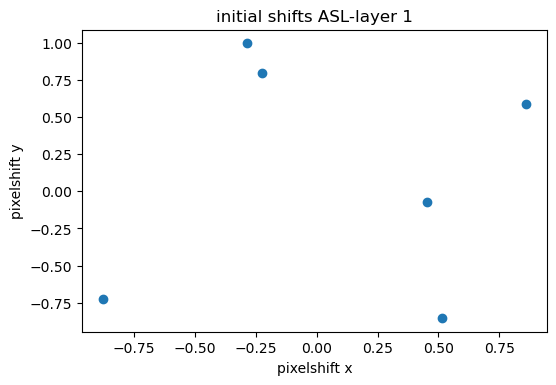

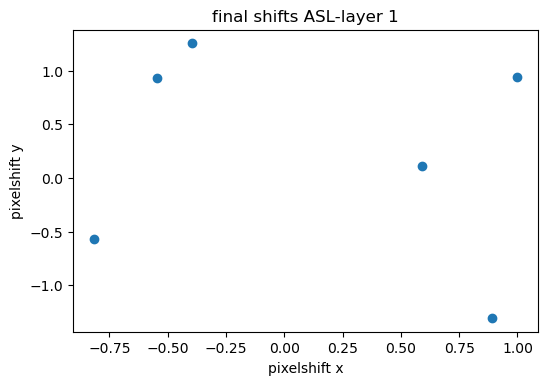

In [7]:
plot_shifts(LeASLNN)

## MNIST LeASLNet expansion-rate 3

In [11]:
# mock train_function of Optimizer to load the optimizer
ASL_train_function = None

with open('models/LeNet/LeASLNet_optimizer.pkl', 'rb') as file:
    LeASLNet_optim = pickle.load(file)

best_parameters = LeASLNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[2]

[{'acc': 99.64666666666666, 'lr': 0.4318430270465593, 'momentum': 0.5504980468750001, 'p_randomTransform': 0.00041015625000001554}, {'acc': 99.52166666666666, 'lr': 0.47607421875, 'momentum': 0.51025390625, 'p_randomTransform': 0.0224609375}, {'acc': 99.27666666666667, 'lr': 0.031142578125000014, 'momentum': 0.9078222656249999, 'p_randomTransform': 0.5410533338955021}]


In [12]:
from Models import LeASLNet

LeASLNN_exp3 = LeASLNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, expansion_rate=3)

summary(LeASLNN_exp3, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─CSC_block: 2-5                    [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        312
│    │    └─Conv2d: 3-2                  [100, 16, 14, 14]         112
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─T

In [13]:
PATH = "models/LeNet/LeASLNet_exp3.pth"

if exists(PATH):
    LeASLNN_exp3 = torch.load(PATH)
    LeASLNN_exp3.eval()

In [14]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeASLNN_exp3, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.257
test_loss: 0.734, test_accuracy: 73.8
[1,   200] train_loss: 0.412
test_loss: 0.196, test_accuracy: 94.07
[1,   300] train_loss: 0.257
test_loss: 0.160, test_accuracy: 95.04
[1,   400] train_loss: 0.184
test_loss: 0.098, test_accuracy: 96.95
[1,   500] train_loss: 0.157
test_loss: 0.096, test_accuracy: 96.96
[1,   600] train_loss: 0.139
test_loss: 0.096, test_accuracy: 96.96
[2,   100] train_loss: 0.130
test_loss: 0.089, test_accuracy: 97.08
[2,   200] train_loss: 0.112
test_loss: 0.072, test_accuracy: 97.76
[2,   300] train_loss: 0.120
test_loss: 0.071, test_accuracy: 97.79
[2,   400] train_loss: 0.113
test_loss: 0.068, test_accuracy: 97.86
[2,   500] train_loss: 0.099
test_loss: 0.064, test_accuracy: 98.0
[2,   600] train_loss: 0.129
test_loss: 0.067, test_accuracy: 97.81
[3,   100] train_loss: 0.088
test_loss: 0.065, test_accuracy: 97.97
[3,   200] train_loss: 0.097
test_loss: 0.068, test_accuracy: 97.77
[3,   300] train_loss: 0.081
test_loss: 0.062, tes

In [15]:
torch.save(LeASLNN_exp3, "./models/LeNet/LeASLNet_exp3.pth")

In [4]:
LeASLNN_exp3 = torch.load("./models/LeNet/LeASLNet_exp3.pth")

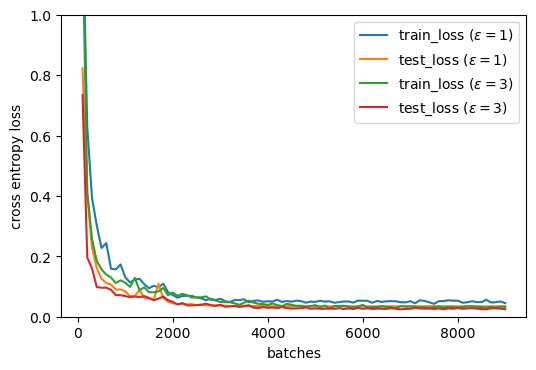

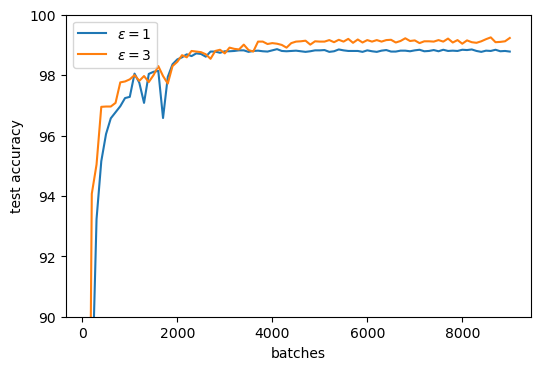

In [13]:
ASL_plot_loss(LeASLNN, LeASLNN_exp3, y_lim=(0,1))
ASL_plot_acc(LeASLNN, LeASLNN_exp3, y_lim=(90, 100))

In [6]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeASLNN_exp3.train_time), 3)}")
print(f"std: {round(np.std(LeASLNN_exp3.train_time), 3)}")

Training time (s):
mean: 0.791
std: 0.144


In [7]:
inference_times = inference_time(LeASLNN_exp3, input_shape=(1, 1, 28, 28), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.132e+00
9.5e-02


In [8]:
inference_times = inference_time(LeASLNN_exp3, input_shape=(1, 1, 28, 28), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
6.852e-01
2.9e-01


In [9]:
inference_times = inference_time(LeASLNN_exp3, input_shape=(100, 1, 28, 28), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
2.259e+00
5.2e-02


In [10]:
inference_times = inference_time(LeASLNN_exp3, input_shape=(100, 1, 28, 28), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
4.255e+00
6.0e-01


## MNIST LeDepthNet

In [20]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet/LeDepthNet_optimizer.pkl', 'rb') as file:
    LeDepthNet_optim = pickle.load(file)

best_parameters = LeDepthNet_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

[{'acc': 99.40833333333333, 'lr': 0.385712890625, 'momentum': 0.5377679553024513, 'p_randomTransform': 0.017723451102000187}, {'acc': 99.36833333333334, 'lr': 0.3125, 'momentum': 0.5625, 'p_randomTransform': 0.375}, {'acc': 99.35666666666667, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}]


In [21]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Depth_wise_block: 2-5             [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─Tanh: 2-10                        [100, 120]                --
│    └─Li

In [7]:
PATH = "models/LeNet/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [8]:
criterion = CrossEntropyLoss()
epochs = 15

train_NN(LeDepthNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 0.675
test_loss: 0.294, test_accuracy: 90.35
[1,   200] train_loss: 0.232
test_loss: 0.150, test_accuracy: 95.23
[1,   300] train_loss: 0.214
test_loss: 0.149, test_accuracy: 95.28
[1,   400] train_loss: 0.156
test_loss: 0.172, test_accuracy: 94.45
[1,   500] train_loss: 0.196
test_loss: 0.254, test_accuracy: 91.96
[1,   600] train_loss: 0.192
test_loss: 0.184, test_accuracy: 94.35
[2,   100] train_loss: 0.186
test_loss: 0.149, test_accuracy: 95.44
Epoch 00007: reducing learning rate of group 0 to 1.9286e-01.
[2,   200] train_loss: 0.167
test_loss: 0.108, test_accuracy: 96.85
[2,   300] train_loss: 0.107
test_loss: 0.084, test_accuracy: 97.48
[2,   400] train_loss: 0.092
test_loss: 0.109, test_accuracy: 96.67
[2,   500] train_loss: 0.108
test_loss: 0.099, test_accuracy: 96.98
[2,   600] train_loss: 0.078
test_loss: 0.065, test_accuracy: 98.05
[3,   100] train_loss: 0.109
test_loss: 0.070, test_accuracy: 97.95
[3,   200] train_loss: 0.060
test_loss: 0.062, test_ac

In [12]:
torch.save(LeDepthNN, "./models/LeNet/LeDepthNet.pth")

In [7]:
LeDepthNN = torch.load("./models/LeNet/LeDepthNet.pth")

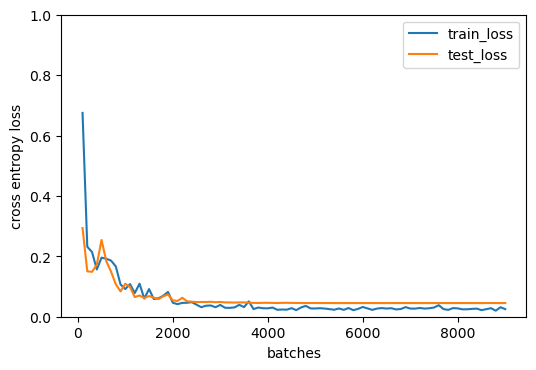

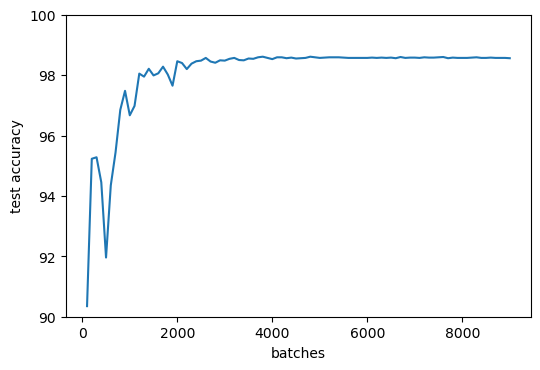

In [9]:
plot_loss(LeDepthNN, y_lim=(0,1))
plot_acc(LeDepthNN, y_lim=(90,100))

In [23]:
print("Training time (s):")
print(f"mean: {round(np.mean(LeDepthNN.train_time), 3)}")
print(f"std: {round(np.std(LeDepthNN.train_time), 3)}")

Training time (s):
mean: 0.557
std: 0.123


In [26]:
inference_times = inference_time(LeDepthNN, input_shape=(1, 1, 28, 28), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
4.341e-01
8.1e-02


In [27]:
inference_times = inference_time(LeDepthNN, input_shape=(1, 1, 28, 28), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
4.208e-01
8.0e-02


In [28]:
inference_times = inference_time(LeDepthNN, input_shape=(100, 1, 28, 28), repetitions=10000, device="cuda")
print("Inference time GPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time GPU (ms):
1.331e+00
1.2e-01


In [29]:
inference_times = inference_time(LeDepthNN, input_shape=(100, 1, 28, 28), repetitions=10000, device="cpu")
print("Inference time CPU (ms):")
print(format(np.mean(inference_times), ".3e"))
print(format(np.std(inference_times), ".1e"))

Inference time CPU (ms):
2.037e+00
5.4e-01
